In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# set project folder directory
DATA_DIR = '/content/drive/MyDrive/W281 Project/data'

In [ ]:
# load some lib
import os
import glob
import re
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import joblib
import cv2 as cv


# read in metadata
df_meta = pd.read_csv(f"{DATA_DIR}/raw/Chest_xray_Corona_Metadata.csv", index_col = 0)
df_meta_train = df_meta[df_meta['Dataset_type'] == 'TRAIN']
df_meta_test = df_meta[df_meta['Dataset_type'] == 'TEST']
df_meta_train

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
...,...,...,...,...,...
5304,1-s2.0-S0929664620300449-gr2_lrg-c.jpg,Pnemonia,TRAIN,COVID-19,Virus
5305,1-s2.0-S0929664620300449-gr2_lrg-b.jpg,Pnemonia,TRAIN,COVID-19,Virus
5306,1-s2.0-S0929664620300449-gr2_lrg-a.jpg,Pnemonia,TRAIN,COVID-19,Virus
5307,1-s2.0-S0140673620303706-fx1_lrg.jpg,Pnemonia,TRAIN,COVID-19,Virus


In [ ]:
# df_meta_train[df_meta_train['X_ray_image_name'] == 'streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day1.jpeg']

In [ ]:
# read in summary of data set
df_data_summary = pd.read_csv(f"{DATA_DIR}/raw/Chest_xray_Corona_dataset_Summary.csv", index_col = 0)
df_data_summary['Label_2_Virus_category'] = np.where((df_data_summary['Label'] == 'Normal'), 
                                              'Normal',
                                              np.where(
                                                  (df_data_summary['Label_2_Virus_category'] != df_data_summary['Label_2_Virus_category']) & 
                                                  ~(df_data_summary['Label_1_Virus_category'] != df_data_summary['Label_1_Virus_category']),
                                                  df_data_summary['Label_1_Virus_category'],
                                                  df_data_summary['Label_2_Virus_category']
                                              ))

df_data_summary['Label_1_Virus_category'] = np.where((df_data_summary['Label'] == 'Normal'), 
                                              'Normal',df_data_summary['Label_1_Virus_category']
                                              )

df_data_summary

,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,Normal,Normal,Normal,1576
1,Pnemonia,Stress-Smoking,ARDS,2
2,Pnemonia,Virus,Virus,1493
3,Pnemonia,Virus,COVID-19,58
4,Pnemonia,Virus,SARS,4
5,Pnemonia,bacteria,bacteria,2772
6,Pnemonia,bacteria,Streptococcus,5


In [ ]:
# get an image
# load image data
def grab_one_and_plot(df, col_category, data_set = 'train'):
  """
    For data visualization, grab each image from the specified column directory
    Show the image
  """
  # copy the meta; avoid mutation
  df_copy = df.copy()


  # instantitae canvas for plotting
  plt.figure(figsize=(15,5))

  for i, cat in enumerate(df_copy[col_category].unique()):

      print(cat)

      # locate the image and build path to the image
      img_meta = df_copy[df_copy[col_category] == cat].iloc[103]
      train_test = data_set
      path = f"{DATA_DIR}/raw/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/{train_test}/{img_meta['X_ray_image_name']}"


      # grab the image path and plot
      img = Image.open(path)
      plt.subplot(1, len(df_copy[col_category].unique()), i+1)
      plt.imshow(img, cmap='gray')
      plt.axis('off')
      plt.title(f"{train_test}: {cat} Chest X-ray")
      
      
  plt.show()

# grab_one_and_plot(df_meta, "Label", "train_resized")

In [ ]:
# get all available test images
unique_images = df_meta_train['X_ray_image_name'].unique()
img_names_list = []

for img in unique_images:
  img_name = img.split(".")[0]
  if img_name not in img_names_list:
    img_names_list.append(img_name)

# img_names_list[:5]

In [ ]:
len(img_names_list)

5272

0it [00:00, ?it/s]

augmented_IM-0128-0001_0_8567.jpeg
(224, 224)
[[255 255 255 ... 255 255 227]
 [255 255 255 ... 255 255 227]
 [241 248 240 ... 255 239 195]
 ...
 [255  62  62 ... 240 248 224]
 [255  62  60 ... 240 248 224]
 [143  14  14 ... 128 137 128]]
LBP Program is finished


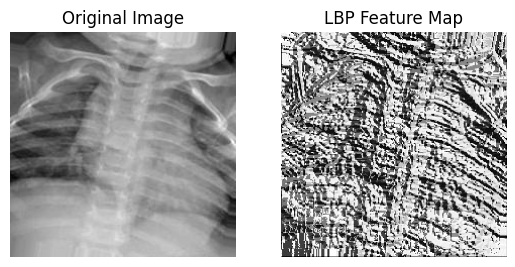

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


def get_pixel(img, center, x, y):
      
    new_value = 0
      
    try:
        # If local neighbourhood pixel 
        # value is greater than or equal
        # to center pixel values then 
        # set it to 1
        if img[x][y] >= center:
            new_value = 1
              
    except:
        # Exception is required when 
        # neighbourhood value of a center
        # pixel value is null i.e. values
        # present at boundaries.
        pass
      
    return new_value
    
   
# Function for calculating LBP
def lbp_calculated_pixel(img, x, y):
    center = img[x][y]
    val_ar = []
    # top_left
    val_ar.append(get_pixel(img, center, x-1, y-1))
    # top
    val_ar.append(get_pixel(img, center, x-1, y))
    # top_right
    val_ar.append(get_pixel(img, center, x-1, y + 1))
    # right
    val_ar.append(get_pixel(img, center, x, y + 1))
    # bottom_right
    val_ar.append(get_pixel(img, center, x + 1, y + 1))
    # bottom
    val_ar.append(get_pixel(img, center, x + 1, y))
    # bottom_left
    val_ar.append(get_pixel(img, center, x + 1, y-1))
    # left
    val_ar.append(get_pixel(img, center, x, y-1))
    # Now, we need to convert binary
    # values to decimal
    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
    val = 0
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
    return val


lbp_features = {}

for i, img in tqdm(enumerate(img_names_list)):
  # if i >= 5216:
    path = f"{DATA_DIR}/raw/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train_resized_augmented/"
    img_name = "augmented_"+img+"_"
    aug_images_list = list(pathlib.Path(path).glob(f'{img_name}*.jpeg'))

    for aug_img_path in aug_images_list:
        img_path = str(aug_img_path)
        img_name = img_path[len(path):]
        img_bgr = cv2.imread(img_path, 1)
        
        height, width, _ = img_bgr.shape
        
        # We need to convert RGB image 
        # into gray one because gray 
        # image has one channel only.
        img_gray = cv2.cvtColor(img_bgr,
                                cv2.COLOR_BGR2GRAY)
        
        # Create a numpy array as 
        # the same height and width 
        # of RGB image
        img_lbp = np.zeros((height, width),
                        np.uint8)
        
        for i in range(0, height):
            for j in range(0, width):
                img_lbp[i, j] = lbp_calculated_pixel(img_gray, i, j)
        
        lbp_features[img_path[len(path):]] = img_lbp
        print(img_name)
        print(img_lbp.shape)
        print(img_lbp)

        plt.subplot(1, 2, 1)
        plt.imshow(img_bgr)
        plt.title('Original Image')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(img_lbp, cmap ="gray")
        plt.title('LBP Feature Map')
        plt.axis('off')
        
        print("LBP Program is finished")
        break
    break

In [ ]:
# duplicate_images

In [ ]:
# len(sift_features)

In [ ]:
# list(sift_features)[-1]

In [ ]:
import pickle
pickle.dump(lbp_features, open(f"{DATA_DIR}/processed/lbp_features_p2.pkl", "wb"))

In [ ]:
lbp_features_1 = pickle.load(open(f"{DATA_DIR}/processed/lbp_features_p1.pkl", "rb"))
lbp_features_2 = pickle.load(open(f"{DATA_DIR}/processed/lbp_features_p2.pkl", "rb"))

In [ ]:
lbp_features_1.update(lbp_features_2)

In [ ]:
pickle.dump(lbp_features_1, open(f"{DATA_DIR}/processed/lbp_features.pkl", "wb"))